In [70]:
import stormvogel.model
from stormvogel.layout import Layout
from stormvogel.show import show

We create a grid POMDP and show it in two ways. Can you see the correspondence?

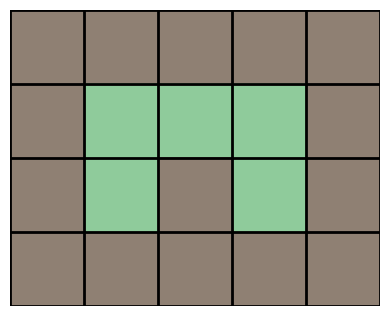

In [123]:
WALL = 1
NOT_WALL = 0
OUT_OF_BOUNDS = -1

WALL_SYM = "X"
EMPTY_SYM = "."

LEFT = "←"
RIGHT = "→"
UP = "↑"
DOWN = "↓"

def out_of_bounds(x, y, width, height):
    return x < 0 or y < 0 or x > width-1 or y > height -1

def direction_result(x: int, y: int, direction: str, level_list: list, width: int, height: int):
    d = {UP: (0,-1), RIGHT: (1,0), DOWN: (0,1), LEFT:(-1,0)}
    res_x = x + d[direction][0]
    res_y = y + d[direction][1]
    if out_of_bounds(res_x,res_y,width,height):
        return ((res_x,res_y), OUT_OF_BOUNDS)
    if level_list[res_y][res_x] == WALL_SYM:
        return ((x,y), WALL)
    else:
        return ((res_x, res_y), NOT_WALL)

def grid_world(level:list, position_scalar:int=200):
    """Create a grid world with an actor."""
    level_list = list(filter(lambda x: x != "", level.splitlines()))
    width = len(level_list[0])
    height = len(level_list)
    
    pomdp = stormvogel.model.new_pomdp(create_initial_state=False)
    grid = [[pomdp.new_state(["t", f"({x},{y})"]) if not level_list[y][x] == WALL_SYM else None
        for x in range(width)] for y in range(height)]
    dirs = {d: pomdp.new_action(d) for d in [UP, DOWN, LEFT, RIGHT]}
    positions = {}
    # Add movement
    for x in range(width):
        for y in range(height):
            if not grid[y][x] is None:
                for d,action in dirs.items():
                    positions[str(grid[y][x].id)] = {"x": x * position_scalar, "y": y * position_scalar}
                    ((res_x, res_y), observation) = direction_result(x,y,d,level_list,width,height)
                    if not observation == OUT_OF_BOUNDS:
                        took_dir = pomdp.new_state([d, f"({x},{y})"])
                        grid[y][x].add_transitions([(action, took_dir)])
                        took_dir.add_transitions([(1, grid[res_y][res_x])])
                        took_dir.set_observation(observation)
    return pomdp, positions

LEVEL ="""
XXXXX
X...X
X.X.X
XXXXX
"""
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

def show_grid(level, hor_size):
    # https://stackoverflow.com/questions/19586828/drawing-grid-pattern-in-matplotlib
    d = {WALL_SYM: 1, EMPTY_SYM: 0}
    level_list = list(filter(lambda x: x != "", level.splitlines()))
    level_list = list(map(
        lambda x: list(map(lambda y: d[y], x)), 
        level_list))
    width = len(level_list[0])
    height = len(level_list)
    
    # make a figure + axes
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    fig.set_size_inches(hor_size, hor_size)
    # make color map
    my_cmap = matplotlib.colors.ListedColormap(['#8FCB9B', '#8F8073'])
    # draw the grid
    for x in range(width + 1):
        ax.axvline(x, lw=2, color='k', zorder=5)
    for y in range(height + 1):
        ax.axhline(y, lw=2, color='k', zorder=5)
    
    # draw the boxes
    ax.imshow(level_list, interpolation='none', cmap=my_cmap, extent=[0, width, 0, height], zorder=0, )
    # turn off the axis labels
    ax.axis('off')

pomdp, positions = grid_world(LEVEL)
show_grid(LEVEL, 4)
vis = show(pomdp, save_and_embed=True, positions=positions, layout=Layout("layouts/grid.json"), separate_labels=["t"])

Some things to keep in mind.
* The tiles in the grid that aren't walls have a state t,(x,y)
* From such a tile, you can try to go left, right, top or bottom (these are actions)
* After taking an action, you go to a state with an observation (symbol ⊙). After this you proceed to another tile state.
    + If you try to go into a wall, you observe that you hit a wall (1)
    + If you do not hit a wall, you observe this as well (0)

For example, if you try to go left in tile (3,2), you observe that you hit a wall and you go back to (3,2). However, if you try to go up, you observe that you don't hit a wall and proceed to (3,1).